In [5]:
import json, pandas as pd
import torch
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from generate import blip_caption, build_prompt, llama_generate
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from transformers import CLIPProcessor, CLIPModel


## Generazione prestazioni complete

In [6]:
# Assicurati che la cartella results/ esista
Path("results").mkdir(parents=True, exist_ok=True)

# Carica l’intero test set
with open("data/splits/test.json", encoding="utf-8") as f:
    recs = json.load(f)

rows = []
for r in tqdm(recs, desc="Generating all captions", total=len(recs)):
    img_path = r["img_name"]
    emo      = r["emotion"]
    gold     = r["caption"]

    # 1) Predizione “emozionale” via LLaMA+Ollama
    prompt = build_prompt(r)
    try:
        pred = llama_generate(
            prompt=prompt,
            model="llama3.2",
            temperature=0.7,
            max_length=40
        )
    except Exception as e:
        print(f"Errore su {img_path}: {e}")
        pred = ""

    # 2) Baseline 1: template statico
    baseline1 = f"This picture makes me feel {emo.lower()} because of what I see."

    # 3) Baseline 2: BLIP “vanilla”
    try:
        baseline2 = blip_caption(img_path)
    except Exception as e:
        print(f"Errore BLIP su {img_path}: {e}")
        baseline2 = ""

    rows.append({
        "img_name":   Path(img_path).name,
        "gold":       gold,
        "pred":       pred,
        "baseline1":  baseline1,
        "baseline2":  baseline2,
        "emotion":    emo
    })

# Costruisci il DataFrame e salva il CSV definitivo
df = pd.DataFrame(rows)
out_path = Path("results") / "test_predictions.csv"
df.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"Salvato {len(df)} righe → {out_path}")


Generating all captions: 100%|██████████| 384/384 [39:35<00:00,  6.19s/it]

Salvato 384 righe → results\test_predictions.csv


## Calcolo delle metriche automatiche

In [10]:
# Carica DataFrame con tutte le caption
df = pd.read_csv("results/test_predictions.csv")

refs = list(df["gold"])
hyps_dict = {
    "pred":      list(df["pred"]),
    "baseline1": list(df["baseline1"]),
    "baseline2": list(df["baseline2"])
}

# Inizializza BLEU e ROUGE
smooth_fn = SmoothingFunction().method1
rouge = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

# Inizializza CLIP
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", use_fast=True)
clip_model     = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", use_safetensors=True).eval()
if torch.cuda.is_available():
    clip_model.cuda()

def compute_clip_scores(image_paths, texts, batch_size=16):
    sims = []
    for i in range(0, len(texts), batch_size):
        batch_imgs = [Image.open(p).convert("RGB") for p in image_paths[i : i+batch_size]]
        batch_txt  = texts[i : i+batch_size]

        # 1) Tokenizza i testi
        text_inputs = clip_processor.tokenizer(
            batch_txt,
            padding=True,
            truncation=True,
            return_tensors="pt"
        )

        # 2) Processa le immagini con il nuovo metodo image_processor
        image_inputs = clip_processor.image_processor(
            images=batch_imgs,
            return_tensors="pt"
        )

        # 3) Unisci i due dizionari
        inputs = {**text_inputs, **image_inputs}

        if torch.cuda.is_available():
            inputs = {k: v.cuda() for k, v in inputs.items()}

        # 4) Inferenza CLIP
        with torch.no_grad():
            out = clip_model(**inputs)

        img_emb = out.image_embeds / out.image_embeds.norm(dim=-1, keepdim=True)
        txt_emb = out.text_embeds  / out.text_embeds.norm(dim=-1, keepdim=True)
        sims.append((img_emb * txt_emb).sum(dim=-1).cpu().numpy())

    return np.concatenate(sims)

# Prepara i path delle immagini
img_paths = [
    fn if Path(fn).exists() else str(Path("data/images") / fn)
    for fn in df["img_name"]
]

# Calcola le metriche per ogni modello
results = []
for name, hyps in hyps_dict.items():
    # BLEU-4
    token_refs = [[r.split()] for r in refs]
    token_hyps = [h.split()      for h in hyps]
    bleu4 = corpus_bleu(token_refs, token_hyps,
                        weights=(0.25,)*4,
                        smoothing_function=smooth_fn)
    # ROUGE-L
    rouge_l = np.mean([
        rouge.score(r, h)["rougeL"].fmeasure
        for r, h in zip(refs, hyps)
    ])
    # CLIPScore
    clip_scores = compute_clip_scores(img_paths, hyps)
    clip_mean   = float(np.round(clip_scores.mean(), 4))

    results.append({
        "Model":     name,
        "BLEU-4":    round(bleu4, 4),
        "ROUGE-L":   round(rouge_l, 4),
        "CLIPScore": clip_mean
    })

# Mostra il DataFrame finale
metrics_df = pd.DataFrame(results).set_index("Model")
print(metrics_df)


           BLEU-4  ROUGE-L  CLIPScore
Model                                
pred       0.0004   0.0672     0.2468
baseline1  0.0007   0.0216     0.1957
baseline2  0.0028   0.1492     0.2651


## Analisi delle Metriche Automatiche

Di seguito la tabella riassuntiva delle metriche calcolate sul test set completo (N=384):

| Model      | BLEU-4  | ROUGE-L | CLIPScore |
|------------|---------|---------|-----------|
| **pred**       | 0.0004  | 0.0672  | 0.2468    |
| **baseline1**  | 0.0007  | 0.0216  | 0.1957    |
| **baseline2**  | 0.0028  | 0.1492  | 0.2651    |

### 1. BLEU-4
- **baseline2 (BLIP “vanilla”)** ottiene il punteggio più alto (0.0028), seguita da **baseline1** (0.0007) e infine dalle caption emotive **pred** (0.0004).
- I valori assoluti sono molto bassi (ordine di 10⁻³), tipico negli scenari di image-captioning, dove la generazione libera raramente riproduce parola per parola la caption di riferimento.

### 2. ROUGE-L
- Anche per ROUGE-L vince **baseline2** (0.1492), che conserva più lunghe sottosequenze rispetto al gold.
- **pred** (0.0672) supera comunque la semplice frase template **baseline1** (0.0216), indicando che LLaMA riesce a mantenere almeno alcune frasi o parole comuni con la didascalia originale, pur inserendo l’elemento emozionale.

### 3. CLIPScore
- **baseline2** è ancora prima (0.2651), riflettendo la forte coerenza immagine-testo di un modello addestrato specificamente per captioning.
- Le **pred** (0.2468) si comportano bene: pur sacrificando un po’ di “fedeltà visiva” per inserire il vincolo emozionale, mantengono un buon allineamento visivo (CLIPScore ≈ 0.25).
- **baseline1** (0.1957) è nettamente più bassa, confermando che una frase statica genera la minore corrispondenza visiva.

---

## Conclusioni e Spunti

1. **Trade-off Creatività vs. Accuratezza**
   - Le caption **pred** mostrano un calo netto su BLEU-4 e ROUGE-L rispetto a baseline2, perché privilegiano la componente stilistica/emotiva a scapito del wording “oggettivo”.
   - Tuttavia, il CLIPScore rimane accettabile (solo ~7% sotto baseline2), segno che il modello non perde completamente l’allineamento con la scena visiva.

2. **Limiti della Template Static**
   - **Baseline1** ottiene valori molto bassi in tutte le metriche, mettendo in luce che una frase rigida non riesce né a riprodurre dettagli del gold né a mantenere coerenza visiva.

3. **Prossimi Passi**
   - **Regolazione dei Prompt**: ridurre la temperatura o aggiungere istruzioni (“mantieni almeno X oggetti visivi chiave”) per migliorare overlap e ROUGE.
   - **Fine-Tuning**: utilizzare LoRA su LLaMA per ancorare meglio la generazione ai dati specifici, riducendo le allucinazioni di contenuto.
   - **Data Augmentation**: con parafrasi del gold, per aiutare il modello a riconoscere varianti lessicali del riferimento e aumentare BLEU/ROUGE.

> **In sintesi**, se l’obiettivo prioritario è massimizzare la similarità col gold o la coerenza visiva, BLIP “vanilla” rimane la scelta migliore. Tuttavia, il sistema condizionato a emozione introduce un elemento stilistico che, nonostante il lieve calo automatico, potrà dimostrarsi prezioso in termini di **coinvolgimento e creatività** nella valutazione umana.```


## Grafico confronto metriche

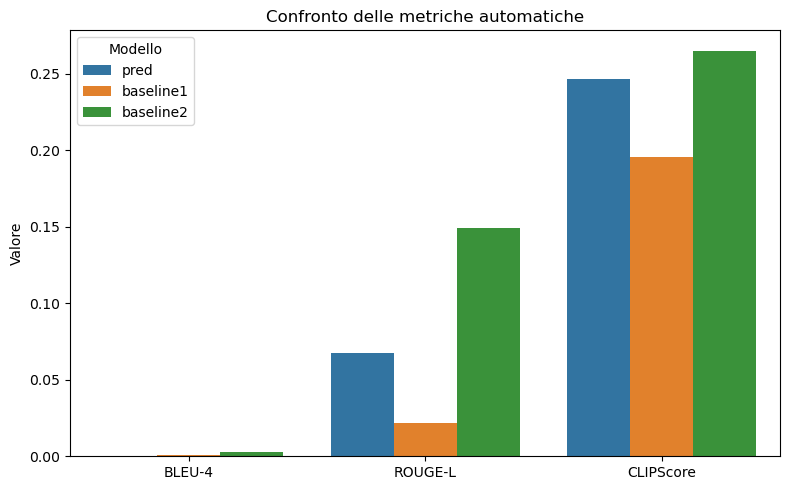

In [11]:
# Partiamo dal DataFrame metrics_df ottenuto in CELL 4
# Se non è in memoria, ricaricalo così:
# metrics_df = pd.read_csv("results/metrics_summary.csv", index_col="Model")

# Trasformazione per seaborn
plot_df = metrics_df.reset_index().melt(
    id_vars="Model",
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=plot_df,
    x="Metric",
    y="Score",
    hue="Model"
)
plt.title("Confronto delle metriche automatiche")
plt.ylabel("Valore")
plt.xlabel("")
plt.legend(title="Modello")
plt.tight_layout()
plt.show()


## Commento al Grafico di Confronto delle Metriche Automatiche

![Confronto delle metriche automatiche](attachment:7f02ff54-b6a2-4c46-8814-d1a603316050.png)

1. **BLEU-4**
   - Tutti i modelli ottengono valori prossimi a zero (ordine di 10⁻³), perché riprodurre esattamente le stesse n-gram del gold in image-captioning è estremamente difficile.
   - **baseline2 (BLIP “vanilla”)** si distingue leggermente (verde), mentre **pred** (blu) e **baseline1** (marrone) sono praticamente sovrapposti sul valore minimo.

2. **ROUGE-L**
   - Qui si vede chiaramente la differenza tra i tre approcci:
     - **baseline2** (verde) guida con un punteggio di circa **0.15**, a indicare la maggiore lunghezza di sottosequenze comuni tra la caption BLIP “standard” e il gold.
     - **pred** (blu) si posiziona a **0.067**, più del triplo di **baseline1** (⚙️ ~0.022), grazie alla capacità di LLaMA di riprendere almeno qualche token chiave del gold, oltre al vincolo emotivo.
     - **baseline1** (marrone), con la semplice frase template, ha il punteggio più basso.

3. **CLIPScore**
   - Anche per la similarità immagine-testo CLIPScore vincono le caption BLIP “vanilla” (**baseline2 ≈ 0.265**).
   - Le **pred** (blu) mantengono un buon livello di coerenza visiva (**≈ 0.247**), circa 7% sotto la baseline2, ma ben distanziate dalle statiche **baseline1** (**≈ 0.196**).

---

### Spunti per il Report

- **Trade-off Creatività vs. “Fedeltà” Visiva**
  Le caption condizionate a emozione (“pred”) cadono leggermente dietro BLIP “vanilla” in tutte le metriche automatiche, ma superano nettamente il template statico “This picture makes me feel…”.
- **Obiettivo di Miglioramento**
  - **Prompt Engineering**: inserire istruzioni più vincolanti (es. “Men­ziona almeno due oggetti chiave oltre all’emozione”) per avvicinare BLEU/ROUGE al gold.
  - **Fine-Tuning LoRA**: ridurre le allucinazioni e ancorare meglio la generazione al contenuto visivo, cercando di recuperare parte della “fedeltà” alla scena.
- **Interpretazione Pratica**
  Anche se il punteggio automatico di **pred** è inferiore a BLIP “vanilla”, il valore aggiunto sta nell’**espressività emotiva**, che non è catturabile da BLEU/ROUGE/CLIPScore ma potrà emergere in una valutazione qualitativa o umana.

Questi risultati confermano che **baseline2** è la scelta migliore per massimizzare le metriche automatiche, ma il tuo sistema **pred** introduce uno stile più narrativo ed emotivo, con un calo accettabile di performance “oggettive”.```
